# Adaptive RAG

Adaptive RAG is a strategy for RAG that uses [query analysis](https://blog.langchain.dev/query-construction/) to route questions to various RAG approaches based on their complexity.

We will borrow some ideas from the [paper](https://arxiv.org/abs/2403.14403), shown in red (below):

* Perform query analysis to route questions

We will also build on some ideas from the Corrective RAG [paper](https://arxiv.org/pdf/2401.15884.pdf), shown in blue (below), and Self-RAG [paper](https://arxiv.org/abs/2310.11511), shown in red:

* Route between our index (vectorstore) and web-search
* Evaluate retrieved documents for relevance to the user question
* Evaluate LLM generations for faithfulness to the documents (e.g., ensure no hallucinations)
* Evaluate LLM generations for usefulness to the question (e.g., does it answer the question)

We implement these ideas from scratch using Mistral and [LangGraph](https://python.langchain.com/docs/langgraph):

* We use a graph to represent the control flow
* The graph state includes information (question, documents, etc) that we want to pass between nodes 
* Each graph node modifies the state 
* Each graph edge decides which node to visit next
 
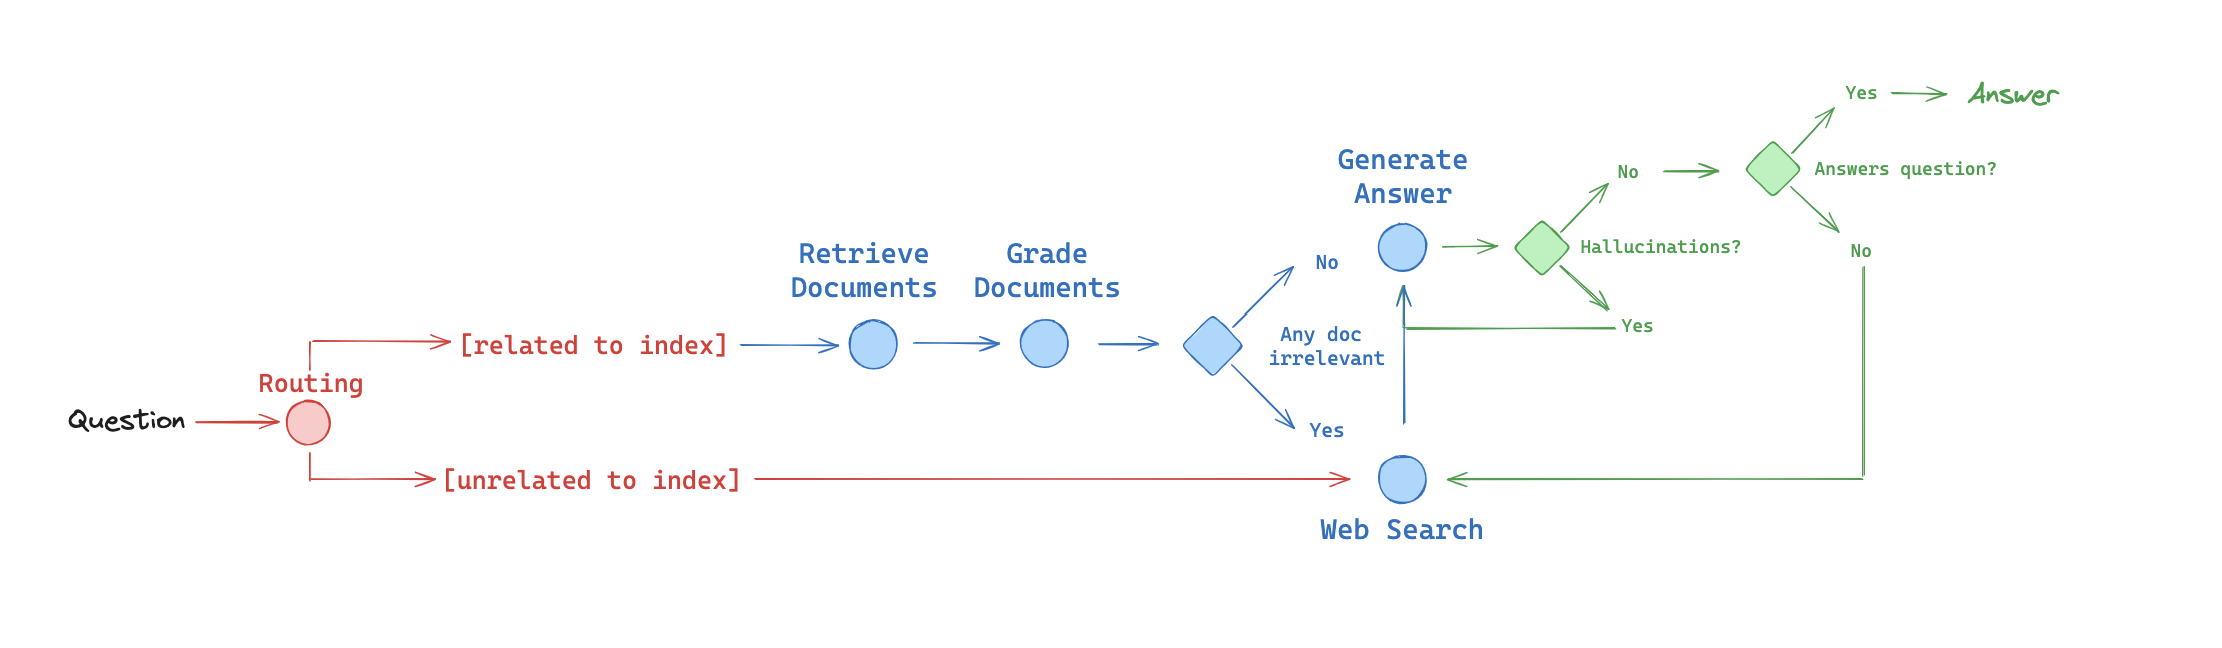

# Environment  

In [4]:
%%capture --no-stderr
%pip install --quiet -U langchain langchain_community tiktoken langchain-mistralai scikit-learn langgraph tavily-python bs4

Ensure your [Mistral API key](https://console.mistral.ai/) is set.

For search, we use [Tavily](https://tavily.com/), which is a search engine optimized for LLMs and RAG. 

In [5]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("MISTRAL_API_KEY")
_set_env("TAVILY_API_KEY")
os.environ['TOKENIZERS_PARALLELISM'] = 'true'

Optionally, you can use [LangSmith](https://docs.smith.langchain.com/) for tracing. 

In [6]:
_set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "mistral-cookbook"

## Index
 
Let's index 3 blog posts with [Mistral embeddings](https://docs.mistral.ai/guides/embeddings/).

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_mistralai import MistralAIEmbeddings

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

# Load documents
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Split documents
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=200
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = SKLearnVectorStore.from_documents(
    documents=doc_splits,
    embedding=MistralAIEmbeddings(),
)

# Create retriever
retriever = vectorstore.as_retriever()

USER_AGENT environment variable not set, consider setting it to identify your requests.
/Users/rlm/Desktop/Code/mistral-cookbook/mistral-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## LLMs

We can use Mistral function calling [to produce structured outputs](https://python.langchain.com/docs/modules/model_io/chat/structured_output/#mistral) at specific nodes.

It will use a flow like this:

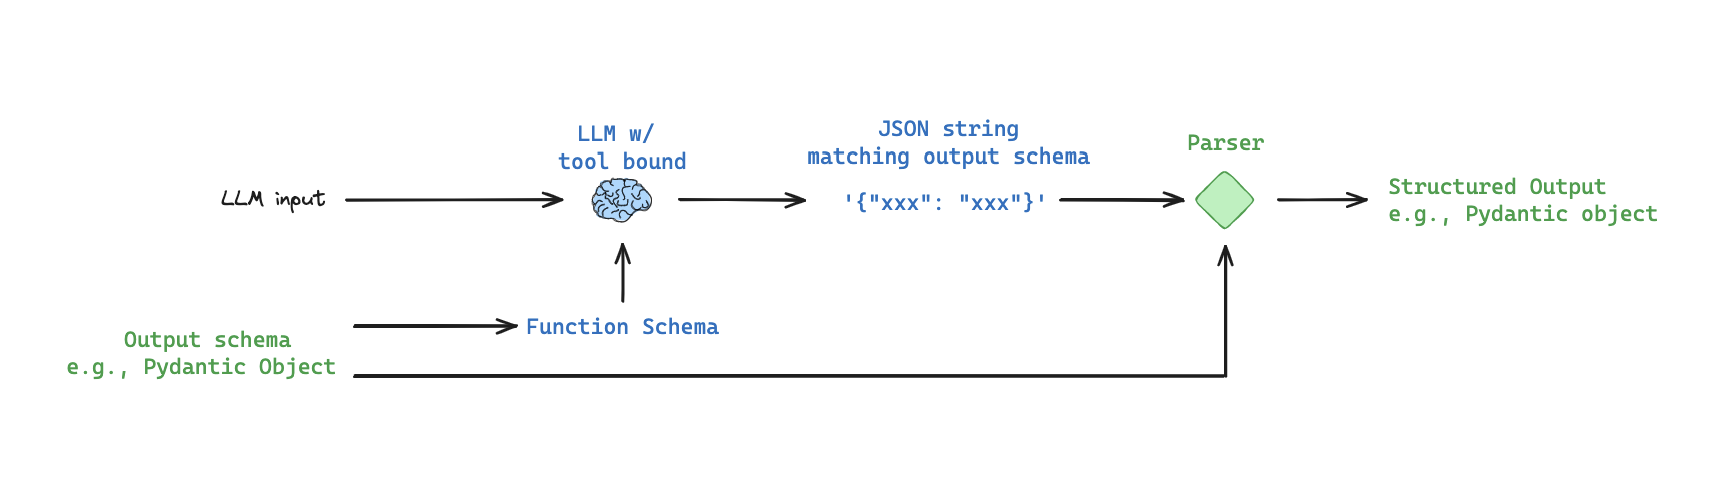

In [8]:
### Set LLM
from langchain_mistralai import ChatMistralAI
mistral_model = "mistral-large-latest" # "open-mixtral-8x22b" 
llm = ChatMistralAI(model=mistral_model, temperature=0)

In [9]:
### Router

from typing import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

# Data model
class RouteQuery(BaseModel):
    """ Route a user query to the most relevant datasource. """

    datasource: Literal["vectorstore", "websearch"] = Field(
        ...,
        description="Given a user question choose to route it to web search or a vectorstore.",
    )

# LLM with structured output
structured_llm_router = llm.with_structured_output(RouteQuery)

# Prompt 
router_instructions = """You are an expert at routing a user question to a vectorstore or web search.

The vectorstore contains documents related to agents, prompt engineering, and adversarial attacks.
                                    
Use the vectorstore for questions on these topics. For all else, use web-search."""

# Test router
print(structured_llm_router.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content="Who will the Bears draft first in the NFL draft?")]))
print(structured_llm_router.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content="What are the types of agent memory?")]))

datasource='websearch'
datasource='vectorstore'


In [10]:
### Retrieval Grader 

from langchain_mistralai import ChatMistralAI
from langchain_core.prompts import ChatPromptTemplate

# Data model
class GradeDocuments(BaseModel):
    """Binary score for relevance check on retrieved documents."""

    binary_score: str = Field(description="Documents are relevant to the question, 'yes' or 'no'")

# LLM with structured output
structured_llm_doc_grader = llm.with_structured_output(GradeDocuments)

# Doc grader instructions 
doc_grader_instructions = """You are a grader assessing relevance of a retrieved document to a user question.

If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.

Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question."""

# Grader prompt
doc_grader_prompt = "Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}"

# Test
question = "agent memory"
docs = retriever.get_relevant_documents(question)
doc_txt = docs[1].page_content
doc_grader_prompt_formatted = doc_grader_prompt.format(document=doc_txt, question=question)
print(structured_llm_doc_grader.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)]))

/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_77692/4241217079.py:27: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  docs = retriever.get_relevant_documents(question)


binary_score='yes'


In [11]:
### Generate

from langchain_core.output_parsers import StrOutputParser

# Prompt
rag_prompt = """You are an assistant for question-answering tasks. 

Use the following pieces of retrieved context to answer the question. 

If you don't know the answer, just say that you don't know. 

Use three sentences maximum and keep the answer concise.

Question: {question} 

Context: {context} 

Answer:"""

# LLM
llm = ChatMistralAI(model=mistral_model, temperature=0)

# Post-processing
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

# Test
question = "The types of agent memory"
docs = retriever.get_relevant_documents(question)
docs_txt = format_docs(docs)
rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
print(generation)

content='The types of agent memory are short-term memory and long-term memory. Short-term memory involves in-context learning, while long-term memory enables the agent to retain and recall information over extended periods using an external vector store and fast retrieval.' additional_kwargs={} response_metadata={'token_usage': {'prompt_tokens': 2876, 'total_tokens': 2928, 'completion_tokens': 52}, 'model': 'mistral-large-latest', 'finish_reason': 'stop'} id='run-989afcac-73d9-4560-8575-753933d8f42a-0' usage_metadata={'input_tokens': 2876, 'output_tokens': 52, 'total_tokens': 2928}


In [12]:
### Hallucination Grader 

# Data model
class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(description="Answer is grounded in the facts, 'yes' or 'no'")
    explanation: str = Field(description="Explain the reasoning for the score")

# LLM with function call 
structured_llm_hallucination_grader = llm.with_structured_output(GradeHallucinations)

# Hallucination grader instructions 
hallucination_grader_instructions = """You are a teacher grading a quiz. 

You will be given FACTS and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is grounded in the FACTS. 

(2) Ensure the STUDENT ANSWER does not contain "hallucinated" information outside the scope of the FACTS.

Score:

A score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of 0 means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
hallucination_grader_prompt = "FACTS: \n\n {documents} \n\n STUDENT ANSWER: {generation}"

# Test using documents and generation from above 
hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=docs_txt, generation=generation)
score = structured_llm_hallucination_grader.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
print(score.binary_score, score.explanation)

yes The student's answer is grounded in the facts provided. It accurately describes the types of agent memory as short-term and long-term, with short-term memory involving in-context learning and long-term memory enabling the agent to retain and recall information over extended periods using an external vector store and fast retrieval. There is no hallucinated information in the student's answer.


In [13]:
### Answer Grader 

# Data model
class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""

    binary_score: str = Field(description="Answer addresses the question, 'yes' or 'no'")
    explanation: str = Field(description="Explain the reasoning for the score")

# LLM with function call 
llm = ChatMistralAI(model=mistral_model, temperature=0)
structured_llm_answer_grader = llm.with_structured_output(GradeAnswer)

# Answer grader instructions 
answer_grader_instructions = """You are a teacher grading a quiz. 

You will be given a QUESTION and a STUDENT ANSWER. 

Here is the grade criteria to follow:

(1) Ensure the STUDENT ANSWER is concise and relevant to the QUESTION

(2) Ensure the STUDENT ANSWER helps to answer the QUESTION

Score:

A score of 1 means that the student's answer meets all of the criteria. This is the highest (best) score. 

A score of 0 means that the student's answer does not meet all of the criteria. This is the lowest possible score you can give.

Explain your reasoning in a step-by-step manner to ensure your reasoning and conclusion are correct. 

Avoid simply stating the correct answer at the outset."""

# Grader prompt
answer_grader_prompt = "QUESTION: \n\n {question} \n\n STUDENT ANSWER: {generation}"

# Test using question and generation from above 
answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=generation)
score = structured_llm_answer_grader.invoke([SystemMessage(content=answer_grader_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])
print(score.binary_score, score.explanation)

yes The student's answer is concise and relevant to the question. It provides a clear explanation of the types of agent memory, including short-term and long-term memory, and describes their functions. This directly addresses the question.


## Web Search Tool

In [14]:
from langchain_community.tools.tavily_search import TavilySearchResults
web_search_tool = TavilySearchResults(k=3)

# Graph 

We build the above workflow as a graph using [LangGraph](https://langchain-ai.github.io/langgraph/).

### Graph state

The graph `state` schema contains keys that we want to:

* Pass to each node in our graph
* Optionally, modify in each node of our graph 

See conceptual docs [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#state).

In [15]:
import operator
from typing_extensions import TypedDict
from typing import List, Annotated

class GraphState(TypedDict):
    """
    Graph state is a dictionary that contains information we want to propagate to, and modify in, each graph node.
    """
    question : str # User question
    generation : str # LLM generation
    web_search : str # Binary decision to run web search
    max_retries : int # Max number of retries for answer generation 
    answers : int # Number of answers generated
    loop_step: Annotated[int, operator.add] 
    documents : List[str] # List of retrieved documents

Each node in our graph is simply a function that:

(1) Take `state` as an input

(2) Modifies `state` 

(3) Write the modified `state` to the state schema (dict)

See conceptual docs [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes).

Each edge routes between nodes in the graph.

See conceptual docs [here](https://langchain-ai.github.io/langgraph/concepts/low_level/#edges).

In [20]:
from langchain.schema import Document
from langgraph.graph import END

### Nodes
def retrieve(state):
    """
    Retrieve documents from vectorstore

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    print("---RETRIEVE---")
    question = state["question"]

    # Write retrieved documents to documents key in state
    documents = retriever.invoke(question)
    return {"documents": documents}

def generate(state):
    """
    Generate answer using RAG on retrieved documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]
    loop_step = state.get("loop_step", 0)
    
    # RAG generation
    docs_txt = format_docs(documents)
    rag_prompt_formatted = rag_prompt.format(context=docs_txt, question=question)
    generation = llm.invoke([HumanMessage(content=rag_prompt_formatted)])
    return {"generation": generation, "loop_step": loop_step+1}

def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question
    If any document is not relevant, we will set a flag to run web search

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Filtered out irrelevant documents and updated web_search state
    """

    print("---CHECK DOCUMENT RELEVANCE TO QUESTION---")
    question = state["question"]
    documents = state["documents"]
    
    # Score each doc
    filtered_docs = []
    web_search = "No" 
    for d in documents:
        doc_grader_prompt_formatted = doc_grader_prompt.format(document=d.page_content, question=question)
        score = structured_llm_doc_grader.invoke([SystemMessage(content=doc_grader_instructions)] + [HumanMessage(content=doc_grader_prompt_formatted)])
        grade = score.binary_score
        # Document relevant
        if grade.lower() == "yes":
            print("---GRADE: DOCUMENT RELEVANT---")
            filtered_docs.append(d)
        # Document not relevant
        else:
            print("---GRADE: DOCUMENT NOT RELEVANT---")
            # We do not include the document in filtered_docs
            # We set a flag to indicate that we want to run web search
            web_search = "Yes"
            continue
    return {"documents": filtered_docs, "web_search": web_search}
    
def web_search(state):
    """
    Web search based based on the question

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Appended web results to documents
    """

    print("---WEB SEARCH---")
    question = state["question"]
    documents = state.get("documents", [])

    # Web search
    docs = web_search_tool.invoke({"query": question})
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)
    documents.append(web_results)
    return {"documents": documents}

### Edges

def route_question(state):
    """
    Route question to web search or RAG 

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """

    print("---ROUTE QUESTION---")
    source = structured_llm_router.invoke([SystemMessage(content=router_instructions)] + [HumanMessage(content=state["question"])]) 
    if source.datasource == 'websearch':
        print("---ROUTE QUESTION TO WEB SEARCH---")
        return "websearch"
    elif source.datasource == 'vectorstore':
        print("---ROUTE QUESTION TO RAG---")
        return "vectorstore"

def decide_to_generate(state):
    """
    Determines whether to generate an answer, or add web search

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """

    print("---ASSESS GRADED DOCUMENTS---")
    question = state["question"]
    web_search = state["web_search"]
    filtered_documents = state["documents"]

    if web_search == "Yes":
        # All documents have been filtered check_relevance
        # We will re-generate a new query
        print("---DECISION: NOT ALL DOCUMENTS ARE RELEVANT TO QUESTION, INCLUDE WEB SEARCH---")
        return "websearch"
    else:
        # We have relevant documents, so generate answer
        print("---DECISION: GENERATE---")
        return "generate"

def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    max_retries = state.get("max_retries", 3) # Default to 3 if not provided

    hallucination_grader_prompt_formatted = hallucination_grader_prompt.format(documents=format_docs(documents), generation=generation.content)
    score = structured_llm_hallucination_grader.invoke([SystemMessage(content=hallucination_grader_instructions)] + [HumanMessage(content=hallucination_grader_prompt_formatted)])
    grade = score.binary_score

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        # Test using question and generation from above 
        answer_grader_prompt_formatted = answer_grader_prompt.format(question=question, generation=generation.content)
        score = structured_llm_answer_grader.invoke([SystemMessage(content=answer_grader_instructions)] + [HumanMessage(content=answer_grader_prompt_formatted)])
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION: GENERATION ADDRESSES QUESTION---")
            return "useful"
        elif state["loop_step"] <= max_retries:
            print("---DECISION: GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
        else:
            print("---DECISION: MAX RETRIES REACHED---")
            return "max retries"  
    elif state["loop_step"] <= max_retries:
        print("---DECISION: GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"
    else:
        print("---DECISION: MAX RETRIES REACHED---")
        return "max retries"  

## Build Graph

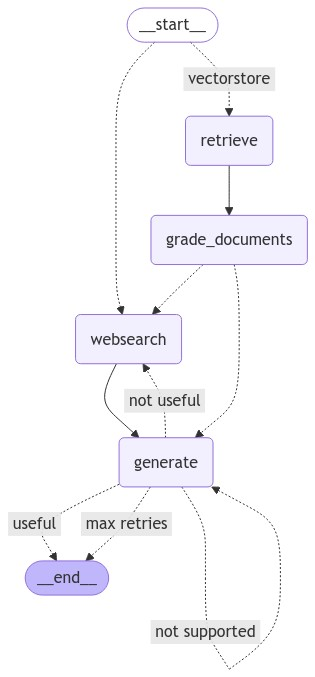

In [25]:
from langgraph.graph import StateGraph
from IPython.display import Image, display

workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("websearch", web_search) # web search
workflow.add_node("retrieve", retrieve) # retrieve
workflow.add_node("grade_documents", grade_documents) # grade documents
workflow.add_node("generate", generate) # generatae

# Build graph
workflow.set_conditional_entry_point(
    route_question,
    {
        "websearch": "websearch",
        "vectorstore": "retrieve",
    },
)
workflow.add_edge("websearch", "generate")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "websearch": "websearch",
        "generate": "generate",
    },
)
workflow.add_conditional_edges(
    "generate",
    grade_generation_v_documents_and_question,
    {
        "not supported": "generate",
        "useful": END,
        "not useful": "websearch",
        "max retries": END,
    },
)

# Compile
graph = workflow.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
graph_input = {"question": "What are the types of agent memory?", "max_retries": 3}
for event in graph.stream(graph_input, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO RAG---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0}
---RETRIEVE---
{'question': 'What are the types of agent memory?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={'id': '3fb33621-a314-49b6-8bf5-4b48db735350', 'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview In a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:', 'language': 'en'}, page_content='Planning\n\nSubgoal and 

Trace: 

https://smith.langchain.com/public/4644990a-6a6c-49b7-8e4e-9b171908a0a5/r

In [22]:
graph_input = {"question": "What is the recent Mistral multi-modal model?", "max_retries": 3}
for event in graph.stream(graph_input, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'What is the recent Mistral multi-modal model?', 'max_retries': 3, 'loop_step': 0}
---WEB SEARCH---
{'question': 'What is the recent Mistral multi-modal model?', 'max_retries': 3, 'loop_step': 0, 'documents': [Document(metadata={}, page_content='Mistral releases Pixtral 12B, its first multimodal model French AI startup Mistral has released its first model that can process images as well as text. Built on one of Mistral’s text models, Nemo 12B, the new model can answer questions about an arbitrary number of images of an arbitrary size given either URLs or images encoded using base64, the binary-to-text encoding scheme. Similar to other multimodal models such as Anthropic’s Claude family and OpenAI’s GPT-4o, Pixtral 12B should — at least in theory — be able to perform tasks like captioning images and counting the number of objects in a photo. Available via a torrent link on GitHub and AI and machine learning development

Trace: 

https://smith.langchain.com/public/a90f2ab9-d684-4b9e-a55a-574767c1147c/r

Try another question, see that it will default to max_retries = 3 if not provided. 

In [24]:
graph_input = {"question": "Who is the top candidate in the 2025 NFL draft?"}
for event in graph.stream(graph_input, stream_mode="values"):
    print(event)

---ROUTE QUESTION---
---ROUTE QUESTION TO WEB SEARCH---
{'question': 'Who is the top candidate in the 2025 NFL draft?', 'loop_step': 0}
---WEB SEARCH---
{'question': 'Who is the top candidate in the 2025 NFL draft?', 'loop_step': 0, 'documents': [Document(metadata={}, page_content="NFL Draft 2025: Big board of top 50 players overall. 1. James Pearce Jr., EDGE, Tennessee (6-5, 243 pounds) Pearce is a naturally explosive and super athletic pass rusher who can become more ...\nRanking top 10 candidates to go No. 1 overall in 2025 NFL Draft: Shedeur Sanders, Carson Beck best QB options We have no idea who could be the top pick next year, let's rank the candidates\n2025 NFL Draft Big Board Top-300. September 21, 2024 1:00 PM EST. 2025 NFL Draft Big Board: 1-100 Below. Players Ranked Regardless of Position. Drafttek.com's Big Board of 2025's top NFL draft prospects is compiled by our internal staff of talent evaluators. The NFL draft prospect rankings are adjusted regularly during the NCAA F

Trace: 

https://smith.langchain.com/public/74d0c510-e139-48be-8c38-f1511e0c8c7a/r